In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lshash import LSHash
from math import radians, cos, sin, asin, sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def input():

    # file input
    data = pd.read_csv('data_2g.csv', index_col=None)
    gongcan = pd.read_csv('2g_gongcan.csv', index_col=None)

    # data merge
    for i in range(1, 8):
        gongcan_temp = gongcan.rename(columns={'RNCID': 'RNCID_' + str(i),'CellID': 'CellID_' + str(i),'Latitude': 'Latitude_' + str(i),'Longitude': 'Longitude_' + str(i)})
        data = pd.merge(data, gongcan_temp, how='left', on=['RNCID_' + str(i), 'CellID_' + str(i)])
        
    # make groups
    groups = []
    for index, row in gongcan.rename(columns={'RNCID': 'RNCID_1','CellID': 'CellID_1'}).iterrows():
        group = pd.merge(data, pd.DataFrame().append(row).drop(['Latitude','Longitude'], axis=1), on=['RNCID_1','CellID_1'])
        if group.size > 1:
            groups.append(group)

    return groups


def classify(data):

    # transfer from absolute to relative
    data['Longitude'] = data['Longitude'] - data['Longitude_1']
    data['Latitude'] = data['Latitude'] - data['Latitude_1']

    return data


def reverse(result, test_set):

    result['Longitude_pred'] = result['lon_pred'] / 100000000.0 + test_set.iloc[0]['Longitude_1']
    result['Latitude_pred'] = result['lat_pred'] / 100000000.0 + test_set.iloc[0]['Latitude_1']

    return result.drop(['lat_pred','lon_pred'], axis=1)


def evaluate(test_set, result_set):

    # calculate the abs range
    compare_set = pd.concat([test_set.reset_index(drop=True), result_set.reset_index(drop=True)], axis=1, ignore_index=True)
    compare_set['lon_dev'] = abs(compare_set[0] - compare_set[2])
    compare_set['lat_dev'] = abs(compare_set[1] - compare_set[3])
    
    # calculate the deviation
    compare_set['error'] = compare_set['lon_dev'] + compare_set['lat_dev']
    compare_set = compare_set.sort_values(['error'])

    # get point
    deviation = [0]
    for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        deviation.append(haversine(compare_set.iloc[int(i*compare_set.shape[0]), ]['error'],0,0,0)*1000)

    return deviation


def createInitSet(data):

    # create training set
    training_set = data.sample(frac=0.8 if data.shape[0] > 2 else 0.5).sort_index()

    training_labels = pd.DataFrame()
    training_labels['Longitude'] = training_set['Longitude'] * 100000000
    training_labels['Latitude'] = training_set['Latitude'] * 100000000
    training_labels['Longitude'] = training_labels['Longitude'].apply(int)
    training_labels['Latitude'] = training_labels['Latitude'].apply(int)

    training_features = training_set.drop(['IMSI','MRTime','Longitude','Latitude','Num_connected','RNCID_1','CellID_1','RNCID_2','CellID_2','RNCID_3','CellID_3','RNCID_4','CellID_4','RNCID_5','CellID_5','RNCID_6','CellID_6','RNCID_7','CellID_7'], axis=1).fillna(0)

    # create test set
    test_set = data.append(training_set).drop_duplicates(keep=False).sort_index()

    test_labels = pd.DataFrame()
    test_labels['Longitude'] = test_set['Longitude'] * 100000000
    test_labels['Latitude'] = test_set['Latitude'] * 100000000
    test_labels['Longitude'] = test_labels['Longitude'].apply(int)
    test_labels['Latitude'] = test_labels['Latitude'].apply(int)

    test_features = test_set.drop(['IMSI','MRTime','Longitude','Latitude','Num_connected','RNCID_1','CellID_1','RNCID_2','CellID_2','RNCID_3','CellID_3','RNCID_4','CellID_4','RNCID_5','CellID_5','RNCID_6','CellID_6','RNCID_7','CellID_7'], axis=1).fillna(0)

    test_pos = pd.DataFrame()
    test_pos['Longitude'] = test_set['Longitude'] + test_set['Longitude_1']
    test_pos['Latitude'] = test_set['Latitude'] + test_set['Latitude_1']

    return training_features, test_features, training_labels, test_labels, test_pos


RandomForestClassifier CDF:


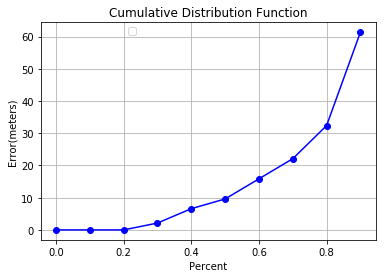

----------Precision----------
Longitude: 
0.0847457627118644 
Latitude: 
0.08050847457627118
----------Recall----------
Longitude: 
0.09256844850065189 
Latitude: 
0.09256844850065189
----------F1----------
Longitude: 
0.0872316384180791 
Latitude: 
0.08440677966101694


D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\py2\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


RandomForestClassifier CDF:


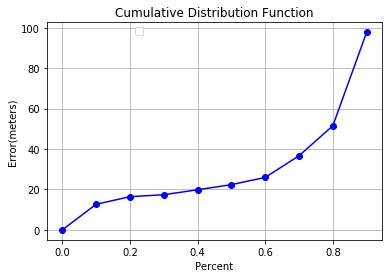

----------Precision----------
Longitude: 
0.015873015873015872 
Latitude: 
0.015873015873015872
----------Recall----------
Longitude: 
0.015873015873015872 
Latitude: 
0.015873015873015872
----------F1----------
Longitude: 
0.015873015873015872 
Latitude: 
0.015873015873015872
RandomForestClassifier CDF:


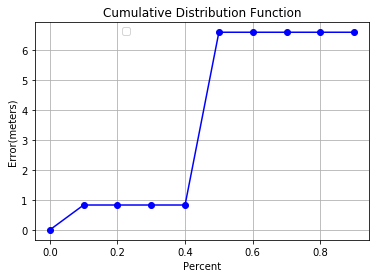

----------Precision----------
Longitude: 
0.3333333333333333 
Latitude: 
0.3333333333333333
----------Recall----------
Longitude: 
0.3333333333333333 
Latitude: 
0.3333333333333333
----------F1----------
Longitude: 
0.3333333333333333 
Latitude: 
0.3333333333333333
RandomForestClassifier CDF:


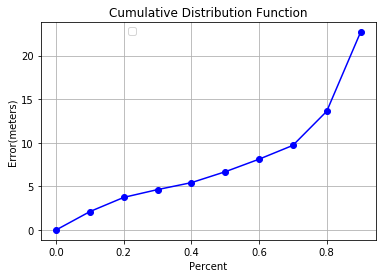

----------Precision----------
Longitude: 
0.03125 
Latitude: 
0.031746031746031744
----------Recall----------
Longitude: 
0.03125 
Latitude: 
0.031746031746031744
----------F1----------
Longitude: 
0.03125 
Latitude: 
0.031746031746031744
RandomForestClassifier CDF:


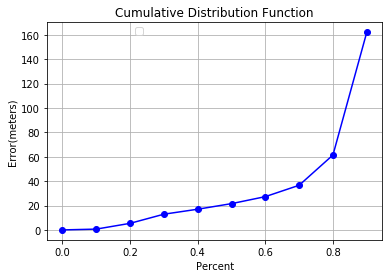

----------Precision----------
Longitude: 
0.04854368932038835 
Latitude: 
0.04854368932038835
----------Recall----------
Longitude: 
0.04854368932038835 
Latitude: 
0.04854368932038835
----------F1----------
Longitude: 
0.04854368932038835 
Latitude: 
0.04854368932038835
RandomForestClassifier CDF:


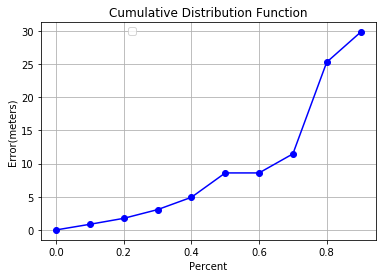

----------Precision----------
Longitude: 
0.4444444444444444 
Latitude: 
0.4444444444444444
----------Recall----------
Longitude: 
0.4444444444444444 
Latitude: 
0.4444444444444444
----------F1----------
Longitude: 
0.4444444444444444 
Latitude: 
0.4444444444444444
RandomForestClassifier CDF:


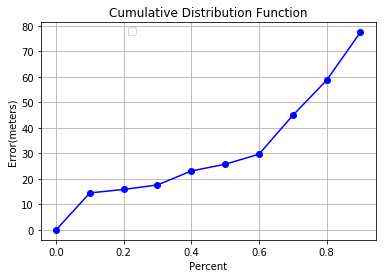

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


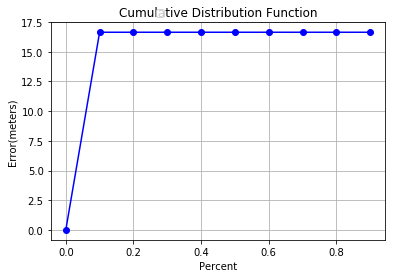

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


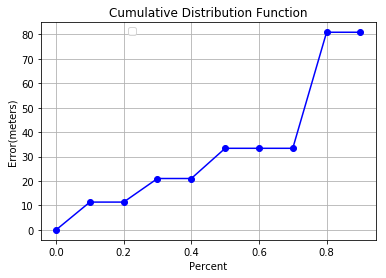

----------Precision----------
Longitude: 
0.16666666666666666 
Latitude: 
0.16666666666666666
----------Recall----------
Longitude: 
0.16666666666666666 
Latitude: 
0.16666666666666666
----------F1----------
Longitude: 
0.16666666666666666 
Latitude: 
0.16666666666666666
RandomForestClassifier CDF:


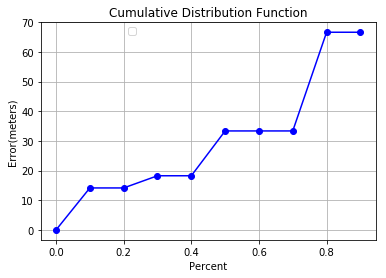

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


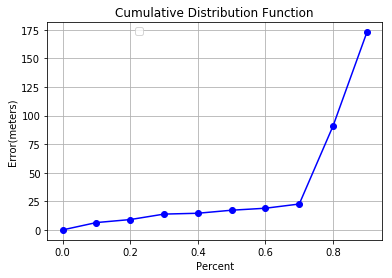

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


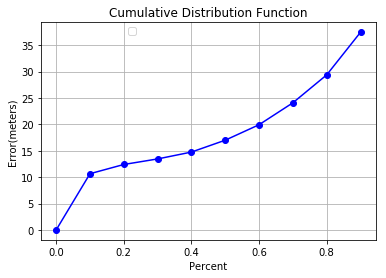

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


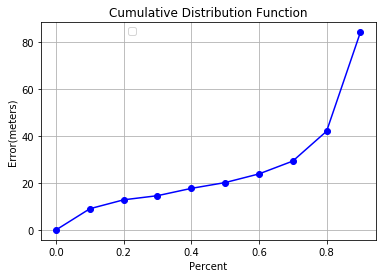

----------Precision----------
Longitude: 
0.024336283185840708 
Latitude: 
0.024774774774774775
----------Recall----------
Longitude: 
0.035398230088495575 
Latitude: 
0.036036036036036036
----------F1----------
Longitude: 
0.027138643067846607 
Latitude: 
0.027627627627627625
RandomForestClassifier CDF:


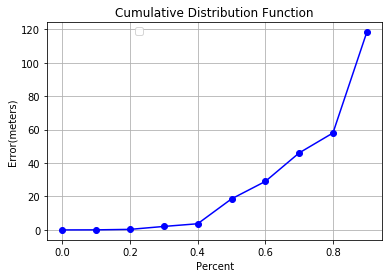

----------Precision----------
Longitude: 
0.03125 
Latitude: 
0.03125
----------Recall----------
Longitude: 
0.0625 
Latitude: 
0.0625
----------F1----------
Longitude: 
0.041666666666666664 
Latitude: 
0.041666666666666664
RandomForestClassifier CDF:


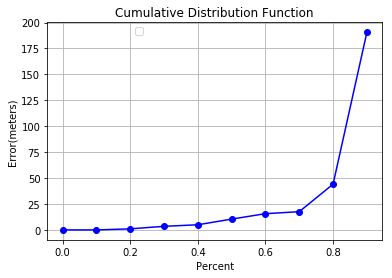

----------Precision----------
Longitude: 
0.06896551724137931 
Latitude: 
0.06896551724137931
----------Recall----------
Longitude: 
0.06896551724137931 
Latitude: 
0.06896551724137931
----------F1----------
Longitude: 
0.06896551724137931 
Latitude: 
0.06896551724137931
RandomForestClassifier CDF:


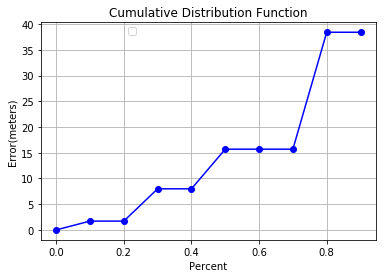

----------Precision----------
Longitude: 
0.08333333333333333 
Latitude: 
0.08333333333333333
----------Recall----------
Longitude: 
0.16666666666666666 
Latitude: 
0.16666666666666666
----------F1----------
Longitude: 
0.1111111111111111 
Latitude: 
0.1111111111111111
RandomForestClassifier CDF:


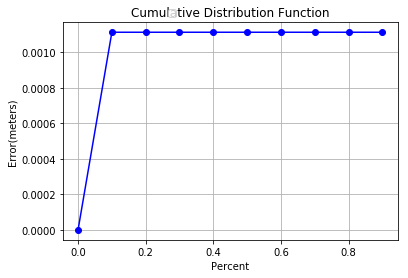

----------Precision----------
Longitude: 
1.0 
Latitude: 
1.0
----------Recall----------
Longitude: 
1.0 
Latitude: 
1.0
----------F1----------
Longitude: 
1.0 
Latitude: 
1.0
RandomForestClassifier CDF:


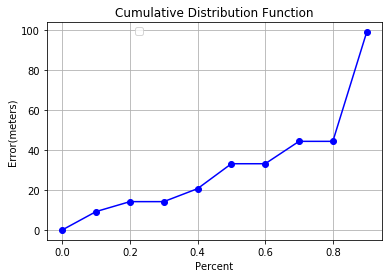

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


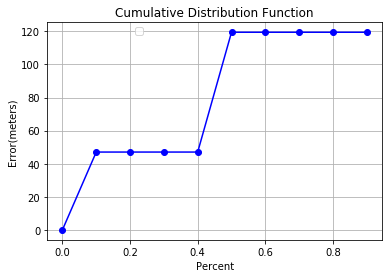

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


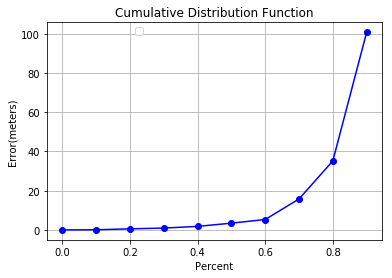

----------Precision----------
Longitude: 
0.041666666666666664 
Latitude: 
0.041666666666666664
----------Recall----------
Longitude: 
0.041666666666666664 
Latitude: 
0.041666666666666664
----------F1----------
Longitude: 
0.041666666666666664 
Latitude: 
0.041666666666666664
RandomForestClassifier CDF:


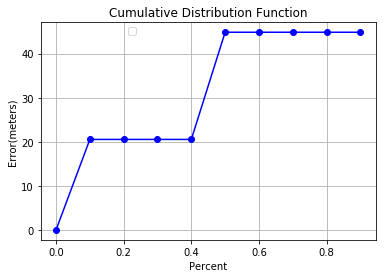

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


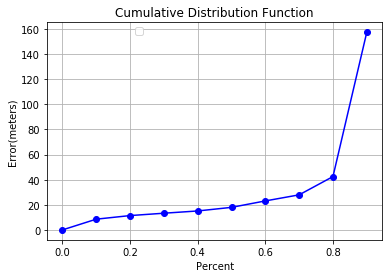

----------Precision----------
Longitude: 
0.0045871559633027525 
Latitude: 
0.013888888888888888
----------Recall----------
Longitude: 
0.009174311926605505 
Latitude: 
0.018518518518518517
----------F1----------
Longitude: 
0.0061162079510703364 
Latitude: 
0.015432098765432098
RandomForestClassifier CDF:


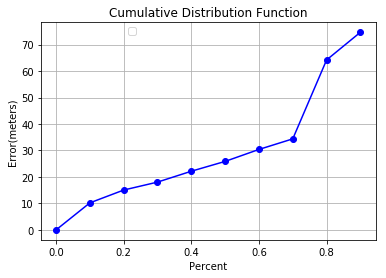

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


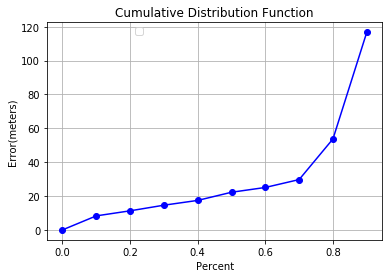

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


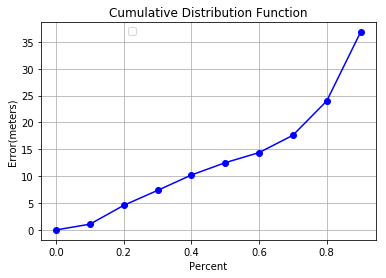

----------Precision----------
Longitude: 
0.0055147058823529415 
Latitude: 
0.0055147058823529415
----------Recall----------
Longitude: 
0.014705882352941176 
Latitude: 
0.014705882352941176
----------F1----------
Longitude: 
0.00784313725490196 
Latitude: 
0.00784313725490196
RandomForestClassifier CDF:


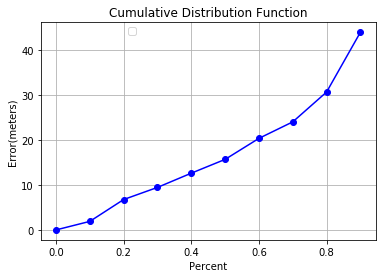

----------Precision----------
Longitude: 
0.047619047619047616 
Latitude: 
0.04618473895582329
----------Recall----------
Longitude: 
0.07142857142857142 
Latitude: 
0.07228915662650602
----------F1----------
Longitude: 
0.055555555555555546 
Latitude: 
0.05421686746987952
RandomForestClassifier CDF:


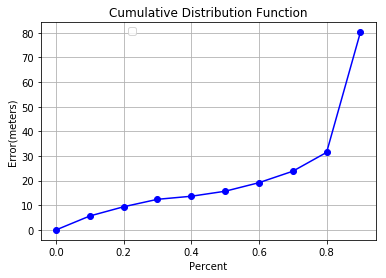

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


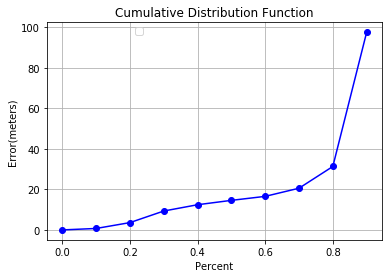

----------Precision----------
Longitude: 
0.01485148514851485 
Latitude: 
0.014778325123152707
----------Recall----------
Longitude: 
0.024752475247524754 
Latitude: 
0.024630541871921183
----------F1----------
Longitude: 
0.017326732673267328 
Latitude: 
0.017241379310344827
RandomForestClassifier CDF:


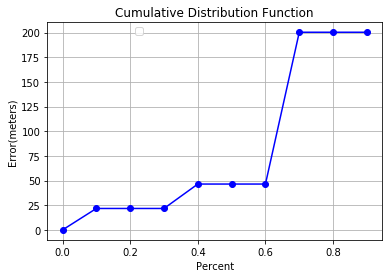

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


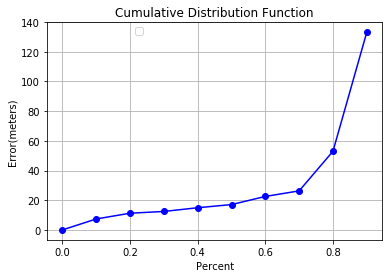

----------Precision----------
Longitude: 
0.022222222222222223 
Latitude: 
0.022222222222222223
----------Recall----------
Longitude: 
0.022222222222222223 
Latitude: 
0.022222222222222223
----------F1----------
Longitude: 
0.022222222222222223 
Latitude: 
0.022222222222222223
RandomForestClassifier CDF:


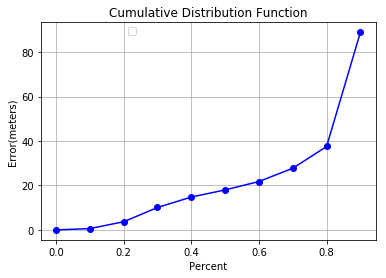

----------Precision----------
Longitude: 
0.03424657534246575 
Latitude: 
0.04794520547945205
----------Recall----------
Longitude: 
0.0410958904109589 
Latitude: 
0.0547945205479452
----------F1----------
Longitude: 
0.0365296803652968 
Latitude: 
0.0502283105022831
RandomForestClassifier CDF:


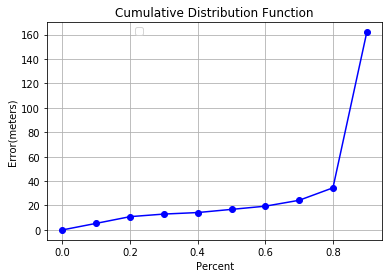

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


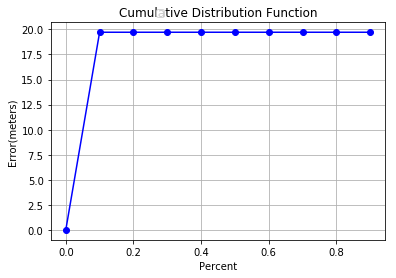

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


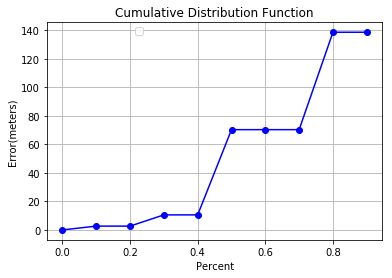

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


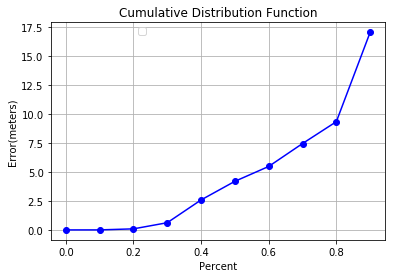

----------Precision----------
Longitude: 
0.09195402298850575 
Latitude: 
0.07222222222222222
----------Recall----------
Longitude: 
0.13793103448275862 
Latitude: 
0.1
----------F1----------
Longitude: 
0.10804597701149425 
Latitude: 
0.08222222222222222
RandomForestClassifier CDF:


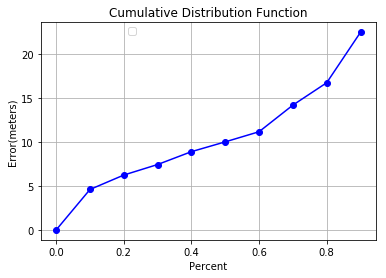

----------Precision----------
Longitude: 
0.009615384615384616 
Latitude: 
0.009259259259259259
----------Recall----------
Longitude: 
0.038461538461538464 
Latitude: 
0.037037037037037035
----------F1----------
Longitude: 
0.015384615384615385 
Latitude: 
0.014814814814814815
RandomForestClassifier CDF:


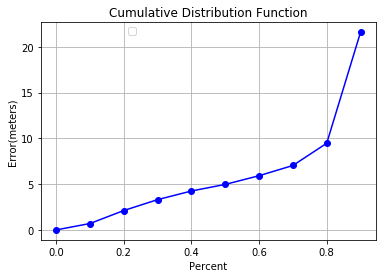

----------Precision----------
Longitude: 
0.1276595744680851 
Latitude: 
0.10416666666666667
----------Recall----------
Longitude: 
0.1276595744680851 
Latitude: 
0.10416666666666667
----------F1----------
Longitude: 
0.1276595744680851 
Latitude: 
0.10416666666666667
RandomForestClassifier CDF:


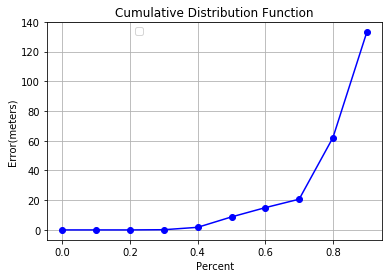

----------Precision----------
Longitude: 
0.20833333333333334 
Latitude: 
0.20833333333333334
----------Recall----------
Longitude: 
0.25 
Latitude: 
0.25
----------F1----------
Longitude: 
0.2222222222222222 
Latitude: 
0.2222222222222222
RandomForestClassifier CDF:


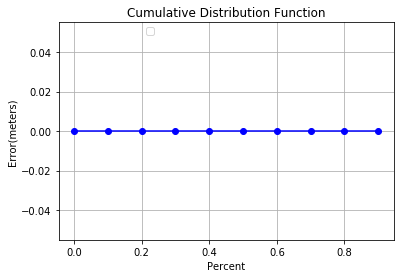

----------Precision----------
Longitude: 
1.0 
Latitude: 
1.0
----------Recall----------
Longitude: 
1.0 
Latitude: 
1.0
----------F1----------
Longitude: 
1.0 
Latitude: 
1.0
RandomForestClassifier CDF:


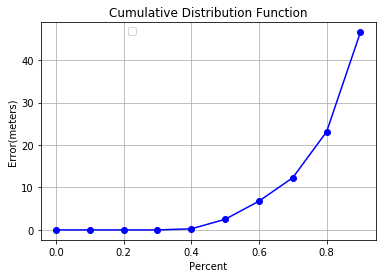

----------Precision----------
Longitude: 
0.05357142857142857 
Latitude: 
0.05357142857142857
----------Recall----------
Longitude: 
0.07142857142857142 
Latitude: 
0.07142857142857142
----------F1----------
Longitude: 
0.05952380952380952 
Latitude: 
0.05952380952380952
RandomForestClassifier CDF:


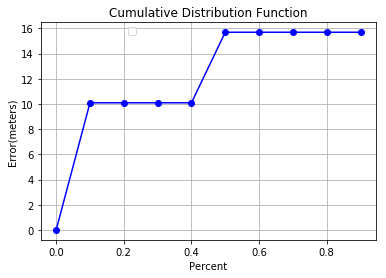

----------Precision----------
Longitude: 
0.0 
Latitude: 
0.0
----------Recall----------
Longitude: 
0.0 
Latitude: 
0.0
----------F1----------
Longitude: 
0.0 
Latitude: 
0.0
RandomForestClassifier CDF:


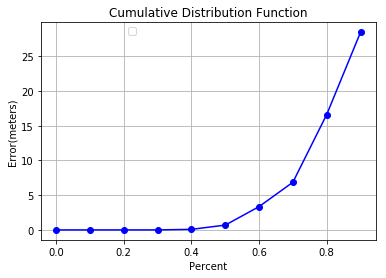

----------Precision----------
Longitude: 
0.08955223880597014 
Latitude: 
0.08974358974358974
----------Recall----------
Longitude: 
0.07462686567164178 
Latitude: 
0.07575757575757576
----------F1----------
Longitude: 
0.07960199004975124 
Latitude: 
0.08020202020202019
RandomForestClassifier CDF:


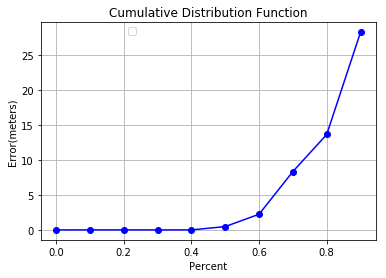

----------Precision----------
Longitude: 
0.0975609756097561 
Latitude: 
0.0975609756097561
----------Recall----------
Longitude: 
0.0975609756097561 
Latitude: 
0.0975609756097561
----------F1----------
Longitude: 
0.0975609756097561 
Latitude: 
0.0975609756097561


In [2]:
if __name__ == '__main__':

    # input
    data_set = input()
    for group in data_set:

        # for each group
        error_set = []
        group_set = classify(group)
        
        for i in range(0, 10):

            # init data set
            training_set, test_set, training_labels, test_labels, test_pos = createInitSet(group_set)

            # RandomForestClassifier
            # train
            clf = RandomForestClassifier().fit(training_set, training_labels)

            # test
            pred = clf.predict(test_set)

            # transform into real pos
            result = reverse(pd.DataFrame(data=pred, columns=['lon_pred', 'lat_pred']), test_set)

            # evaluate
            error_set.append(evaluate(test_pos, result))
            
        # calculate the deviation
        avr_error = []
        error_set = pd.DataFrame(data=error_set)
        for i in range(0, 10):
            avr_error.append(error_set[i].mean())

        # draw the figure
        print 'RandomForestClassifier CDF:'
        group_labels = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        plt.title('Cumulative Distribution Function')  
        plt.xlabel('Percent')  
        plt.ylabel('Error(meters)')
        plt.plot(group_labels, avr_error,'bo-')
        plt.legend(bbox_to_anchor=[0.3, 1])  
        plt.grid()  
        plt.show()

        # Precision
        print '----------Precision----------\nLongitude: \n', precision_score(test_labels['Longitude'], pd.DataFrame(data=pred)[0], average='macro'), '\nLatitude: \n', precision_score(test_labels['Latitude'], pd.DataFrame(data=pred)[1], average='macro')

        # Recall
        print '----------Recall----------\nLongitude: \n', recall_score(test_labels['Longitude'], pd.DataFrame(data=pred)[0], average='macro'), '\nLatitude: \n', recall_score(test_labels['Latitude'], pd.DataFrame(data=pred)[1], average='macro')

        # F-measurement
        print '----------F1----------\nLongitude: \n', f1_score(test_labels['Longitude'], pd.DataFrame(data=pred)[0], average='macro'), '\nLatitude: \n', f1_score(test_labels['Latitude'], pd.DataFrame(data=pred)[1], average='macro')
